<img align="center" width="12%" style="padding-right:10px;" src="../Images/Ccom.png">

# Integrated Seabed Mapping Systems <a href="https://piazza.com/class/jzvaaav18cf2j7"><img src="../Images/help.png"  title="Ask questions on Piazza.com" align="right" width="10%" alt="Piazza.com\"></a><br><br> Lab A: Integration (Fall 2019)

___
This fourth lab is designed to encourage you to implement your own predictionof the performance envelope of a multibeam sonar system.

Using the SonarEquation, and with the knowledge you now have of what controls all the different terms, you are asked to calculate the resulting signal to noise ratio (SNR) for a variety of beam angles asafunction of range.

The plots above are standardly provided with any multibeam operator manual. They represent predictions of the range at which the SNR drops below 10dB. Note that for each plot, the environmental factors are usually stated:
    • Cold or hot ocean
    • Seabed type mud –sand -gravel
    • Noisy/quiet ship.
    
A tool to do this used to be available online (PAMES). Detail about it can be found from:
J. M. Augustin and X. Lurton, "Maximum swath width obtainable with multibeam echosounders-comparison and discussion of experiments vs predictions,"OCEANS '98 Conference Proceedings, Nice, 1998, pp. 234-238 vol.1.doi: 10.1109/OCEANS.1998.725743 http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=725743

In [33]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import pi, sin, cos, log, log10, exp, nan
import matplotlib.pyplot as plt
import scipy.ndimage
import gsw

# import of your own functions

from mycode.absorption import absorption
from mycode.noise_level import noise_level
from mycode.modified_lambertian import modified_lambertian
from mycode.om_plot import om_map

# By default represent numbers in numpy arrays with four decimals
np.set_printoptions(formatter={'all':lambda x: ' '+str('%.8f'%x)})



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<img align="left" width="100%" style="padding-right:10px;" src="../Images/initialization.png">
___
<img align="left" width="6%" style="padding-right:10px;" src="../Images/test.png">
MAIN Deliverable:
For this lab, a plot similar to the standard Kongsberg plot provided in every operator manual is required.

How you go about this in detail is your choice, but you may follow the template laid out by this Notebook and accompanying python scripts. If you build your own you should describe each of the steps. And wherever you have built a specific function, you should explain in detail how you implemented it.



## C.0 Initialization

The code cell below is an example of how the initialize the variables as requested

In [2]:
# Initialization 

f_c= 30000                # Central Frequency
bw=2000                   # Bandwidth in Hz
PWc=25                    # Pulse Width in Cycles
SL=220                    # Source Level re. 1 mu pascal
DI_rx = 20                # Receive Directivity index in dB

# Bottom backscatter strength Sb in dB (Gravel=-20, Sand=-30, Mud=-40)
Sb=[         ['Mud',   'Sand',     'Gravel'],\
    np.array([-40,     -30,        -20]), \
    np.array([ 20,      10,        5]), \
    np.array([5*pi/180, 15*pi/180, 25*pi/180])]
n_bot = len(Sb[0])

len(Sb[1])                # The number of bottom types thus defined
DT = 10                   # Dtection threshold in terms of signal to noise ratio
T = 5                     # Water temp in C
SP=33                     # Salinity in PSU
pH = 8.2                  # Acidity in pH
SS = 4                    # Sea State
SD = 6                    # Shipping Density

# The Sonar Swath
n_beams = 131
swath = 130 * pi /180
th_s = 25 * pi/180
th_i = swath/(n_beams - 1)
th_e = th_s+swath
th = np.arange(th_s,th_e+th_i,th_i)

ph_x = 1*pi/180           # Beamwidth in along track direction
ph_y =ph_x/sin(th)        # Beamwidth in across track direction
pos = [43.0720, -70.7115] # Position in the world

# Create ranges r

r_s = 0.1
r_i = 1
r_e = 7000

r = np.arange(r_s,r_e,r_i)

n_r = len(r)

# MBES is range limited noise, not self noise
# Sound Speed is constant

# Image variables
verbose = True   # Show intermediate output
y_max = 300     # Maximum y-coordinate in image space 

# C.1 Use Thermodynamic Equations to Calculate Sound Speed

From http://www.teos-10.org:

    TEOS-10 is based on a Gibbs function formulation from which all thermodynamic properties of seawater (density, enthalpy, entropy sound speed, etc.) can be derived in a thermodynamically consistent manner. TEOS-10 was adopted by the Intergovernmental Oceanographic Commission at its 25th Assembly in June 2009 to replace EOS-80 as the official description of seawater and ice properties in marine science.

    A significant change compared with past practice is that TEOS-10 uses Absolute Salinity SA (mass fraction of salt in seawater) as opposed to Practical Salinity SP (which is essentially a measure of the conductivity of seawater) to describe the salt content of seawater. Ocean salinities now have units of g/kg.

    Absolute Salinity (g/kg) is an SI unit of concentration. The thermodynamic properties of seawater, such as density and enthalpy, are now correctly expressed as functions of Absolute Salinity rather than being functions of the conductivity of seawater. Spatial variations of the composition of seawater mean that Absolute Salinity is not simply proportional to Practical Salinity; TEOS-10 contains procedures to correct for these effects.

[TEOS-Primer](http://www.teos-10.org/pubs/TEOS-10_Primer.pdf)
   
    The document [What every oceanographer needs to know about TEOS-10 (the "TEOS-Primer" for short)] is a concise summary of the salient theoretical concepts which underpin TEOS-10, while Getting started with the GSW Oceanographic Toolbox of TEOS-10 guides the user through the steps required to process and publish physical oceanographic data using TEOS-10. A detailed explanation of the TEOS-10 thermodynamic description of seawater can be found in the TEOS-10 Manual which has been published by IOC, SCOR and IAPSO. Note that a pdf version of TEOS-10 Lecture Slides is located on the publications page.


### C.1.0 Calculate Absolute Salinity

We installed the gsw 3.3.1 implementaion of the TEOS-10 library for this purpose. Using TEOS-10 for this purpose is absolute overkill, but this is a good excuse to get familiar with it.

Function to calculate absolute salinity

    gsw.SA_from_SP(SP,p,long,lat)

Convert the practical salinity SP to absolute salinity SA:
SP   =  Practical Salinity  (PSS-78)                              [ unitless ]

p    =  sea pressure                                              [dbar] ( ie. absolute pressure - 10.1325 dbar )

long =  longitude in decimal degrees                              [0...360] or [-180...180]

lat  =  latitude in decimal degrees north                         [-90... 90]

In the code cell below calculate absolute salinity

In the code cell below calculate the absolute salinity and assign it to variable `SA`

In [3]:
SA=gsw.SA_from_SP(SP,1,pos[1],pos[0])

### C.1.1 Function to calculate conservative temperature

    gsw.CT_from_t(SA,t,p)

Convert the temperature to conservative temperature CT:
SA  =  Absolute Salinity                                        [ g/kg ]

t   =  in-situ temperature (ITS-90)                             [ deg C]

p   =  sea pressure                                             [ dbar ]

      ( i.e. absolute pressure - 10.1325 dbar )
      

In the code cell below calculate the absolute conservative temperature and assign it to variable `CT`

In [4]:
CT=gsw.CT_from_t(SA,T,1)

### C.1.2  Calculate the sound speed

    gsw.sound_speed_t_exact(SA,T,10.1325)

  sound_speed_T_exact = gsw_sound_speed_t_exact(SA,T,p):
  SA  =  Absolute Salinity                                        [ g/kg ]
  
  T   =  in-situ temperature (ITS-90)                             [ deg C]
  
  p   =  sea pressure                                             [ dbar ]
  
         ( i.e. absolute pressure - 10.1325 dbar )

In the code cell below calculate the sound speed and assign it to variable `C`

In [5]:
C=gsw.sound_speed_t_exact(SA,T,10.1325)

### C.1.2 Calculate the Transmission Loss

TL is comprised of the absorption loss `TLa` and spreading loss `TLs`. We will use the one way `TL` and then enter it twice in the SONAR
equation!! (just to see whether you're paying attention...)

#### C.1.2.1 Calculate  Spreading Loss

In the case of isotropic sound speed `TLs` is purely a function of range. Even though we normally don't have isotropic sound speed we still use a spherical spreading model

$$TLs = 20\cdot log_{10}\left(r \right)$$

In the code cell below calculate the sound speed and assign it to variable `TLs`

In [6]:
TLs=20*log10(r)

#### C.1.2.1 Calculate Absorption Loss

For this segment you  will use the paper [Ainslie M. A., McColm J. G., "A simplified formula for viscous and chemical absorption in sea water", Journal of the Acoustical Society of 
America, 103(3), 1671-1672, 1998.](https://github.com/semmed/ESCI_OE_774_874_Public/blob/master/References/A%20simplified%20formula%20for%20viscous%20and%20chemical%20absorption%20in%20sea%20water.pdf) to calculate the absorption loss of a signal. A template is provided in the file `Absorption.py` in the `mycode` section of this lab

Note that the Absorption function returns the absorption coefficient in dB/km! Also, the absorption is cumulative along a ray and varies with depth. In the code cell below calculate the absorption `TLa` along the ray path of the center of each beam.

In [7]:
TLa=np.zeros((n_r,n_beams))
for i in range(n_beams):

    TLa[:-1,i]=np.cumsum(np.diff(r) / 1000 *absorption(T,r[0:-1]*sin(th[i]),SP,pH,f_c))

    # For correctness' sake add the last value of TLa, even though it is
    # unlikely to make a difference
    
    TLa[-1,i]=TLa[-2,i]+r_i/1000*absorption(T,r[-1]*sin(th[i]),SP,pH,f_c)


Verify the correctness of the above by checking the absorption coefficient for a number of different depths using the following [NPL page](http://resource.npl.co.uk/acoustics/techguides/seaabsorption/)

___
## C.2 Calculate the range of Ambient Noise Levels NL

For the calculation of the ambient noise level use the [handout](https://github.com/semmed/ESCI_OE_774_874_Public/blob/master/References/Underwater%20Acoustics%20and%20Sonar%20SP411%20Handouts%20and%20Notes%20Fall%202006.pdf)

In the code cell determine the background noise and assign it to the variable `NL`

In [8]:
NL=noise_level(SS,SD,f_c,bw,True)

Lower cutoff frequency               : 29000.0 Hz
Upper cutoff frequency               : 31000.0 Hz
Average Shipping noise (Urick,1986)  : 0.0 dB re. 1uPa
Average Surface noise (Knudsen, 1984): 41.39304262026756 dB re. 1uPa
Total Ambient noise                  : 74.40365768843678 dB re. 1uPa


## C.3 Get the backscatter Angular Response curve BS

<img align="left" width="80%" style="padding-right:10px;" src="../Images/backscatter_curve.png">

    Note that we use depression angles whereas in the examples incidence angles are shown!!
    
For the purpose of this lab, you need to have an estimate of the seabed backscatter angular response curve. Typically, most companies pick three seabed types (“mud, sand, gravel)”. As we know from the environmental lecture, the shape of these angular response curves have typical characteristics.

For most grazing angles, mud is weaker than sand which is weaker than gravel. For all three, for grazing angle below ~ 70 (above 20 incidence) the backscatter intensity rolls off non-linearly. A common model for this is Lambertian scattering.

Within 10-20 degrees of normal incidence, however, most seafloors show enhanced scattering that departs from the Lambertian model. The smoother seafloor sediment types (typically the finer grained, lower impedance), tend to exhibit a pronounced specular peak. And the larger the peak, generally the narrower the range of angles away from normal incidence that it is developed.

The simplified model above is suggested as a way of creating a typical angular response. You may use this, or if you prefer another way, go ahead, as long as you explain what you are doing.    
    
In the code cell below determine the backscatter and assign it to the variable `BS`

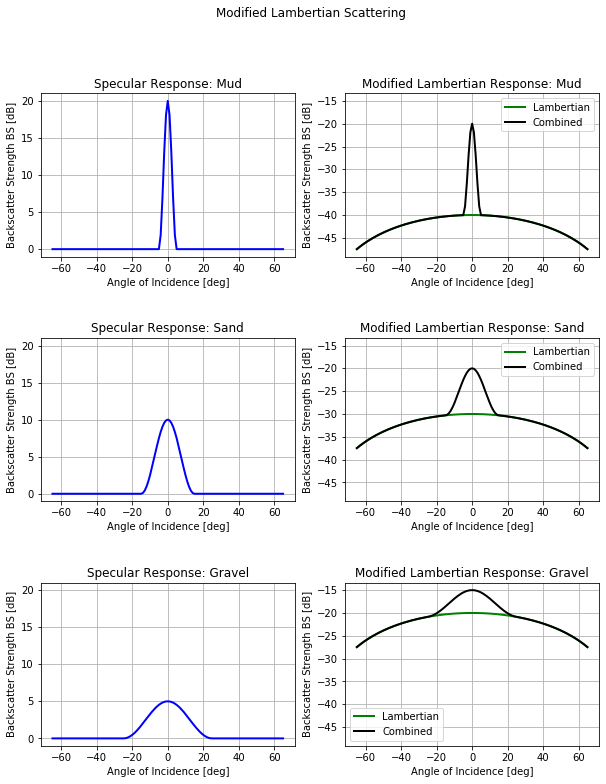

In [9]:
BS=modified_lambertian(th,Sb,verbose)

## C.4 Calculate the Ensonified Area EA

Make the assumption that the seafloor is flat and that each beam reaches the seafloor at the range defined by the detection threshold. 

### Evolution of the projected beam pattern product with obliquity

As the incidence angle grows, so the slant range grows and the receiver beam width grows (as steering increases). All these effects conspire to lengthen the across-track dimension of the projected beam footprint.

Inversely, as the incidence angle grows, the radial dimension of the projected pulse length shortens. Thus there is a transition in the controlling factor on the across-track dimension of the instantaneously ensonified area from:

    •Beam-width limited -near nadir, where the projected pulse length (dx) is greater than the across track projected beam footprint
    •Pulse-Length limited –away from nadir where the projected pulse length is now smaller than the across track beam footprint.


<img align="left" width="80%" style="padding-right:10px;" src="../Images/EA.png">

As Urick recognized, over half a century ago, the total backscattered intensity is related to the instantaneously ensonifiedarea. This is related to the angular and range resolution of the sonar used.

This shows the simplified geometry that you might consider to estimate the Instantaneously Ensonified Area parameter that is part of the in the Bottom Target Strength term in the Sonar Equation.

While the real footprint is either a projection of an elliptical beam, or the truncation of an annulus, such simplifying geometries are commonly applied in most backscatter post-processing software.

Beamwidth limited Area:   

$$A_{bl}=R^2\cdot \phi_X \cdot \frac{\phi_Y}{sin\theta}$$

Pulse Width limited Area: 

$$A_{pl}= \frac{PW_m}{|cos\theta|}\cdot R \cdot \phi_X$$

Thus crossover at:

$$Abl=APl \Rightarrow $$

$$Rc=PW_m \cdot \frac{sin\theta}{\phi_Y\cdot|cos\theta|}$$
<br><br>
Feel free to use a geometry similar to this. If you wish to try another function, that is fine also.


### C.4.1 Calculate Half Pulse Width

Start by calculating the half pulse width $PWm$ in m (half, because we are dealing with a mono-static active sonar) and assign it to the variable `PWm`

In [10]:
PWm=PWc/f_c*C/2

### C.4.2 Calculate the cross-over range 

Calculate the cross-over range and assign it to the variable `Rc` in the code cell below

In [11]:
Rc=sin(th)*PWm/(ph_y*abs(cos(th)))

[ 6.90775571  7.49445229  8.10828133  8.74983409  9.41974969  10.11871910
  10.84748954  11.60686933  12.39773331  13.22102882  14.07778234
  14.96910687  15.89621018  16.86040398  17.86311426  18.90589275
  19.99042990  21.11856940  22.29232469  23.51389743  24.78569865
  26.11037263  27.49082419  28.93024984  30.43217356  32.00048786
  33.63950125  35.35399308  37.14927745  39.03127758  41.00661309
  43.08270258  45.26788491  47.57156317  50.00437660  52.57840678
  55.30742657  58.20720233  61.29586333  64.59435640  68.12700966
  71.92223723  76.01342770  80.44007501  85.24923228  90.49740192
  96.25302255  102.59978484  109.64111775  117.50635694  126.35938069
  136.41094680  147.93672347  161.30433563  177.01516369  195.77122167
  218.58662059  246.98262941  283.34993112  331.67313469  399.12470150
  500.04976125  667.92055966  1003.15424894  2007.83742152
  23476487304686452.00000000  2007.83742151  1003.15424894  667.92055966
  500.04976125  399.12470150  331.67313469  283.349931

### C.4.3 Calculate the Ensonified Area

In the code cell below loop through all the beams and for each range determine the Ensonified Area EA, assign the outcomes to the array `EA`. `EA` should have `n_r` rows and `n_beams` columns so that for beam 32 at a distance of 2.1m the EA will be at `EA[31,2]`


In [12]:
EA=np.zeros((n_r,n_beams))
for i in range(n_beams):

    # Calculate the beamwidth limited areas EA for all R up to Rc
    EA[r<=Rc[i],i]=(r[r<=Rc[i]]**2)*ph_x*ph_y[i]/sin(th[i])
    
    # Calculate the pulsewidth limited areas EA for all R beyond Rc
    EA[r>Rc[i],i]=r[r>Rc[i]]*ph_x*PWm/abs(cos(th[i]))

# Convert to decibels for the sonar equation


### C.4.4 Convert to decibels for the sonar equation

$$EA=10\cdot log_{10}\left( EA \right) $$

In the code cell below convert `EA` to decibels.

In [13]:
EA=10*log10(EA)

## A Word About Handling Arrays in Python

In this step we will be transposing a vector that we extract from a matrix. In `numpy`
a 1-D vector cannot be transposed as it is truly one-dimensional, and the concept of 
transposition is to swap the dimensions.

Thus to transpose a vector it needs to be two-dimensional! This can be very confusing until
you get used to it. The popular *Matlab* and *R* numerical packages do not impose this constriction,
so if you are used to working with them this will be a big adjustment!

This can be particularly confusing if you extract a column from a matrix. For example if
you create a 2-D matrix `A` as follows:

    A = np.asarray(range(12)).reshape((3,4))
    
If you then extract the first row `A[1,:]` the result is: `array([4, 5, 6, 7])` with shape `(4,)`. 
Its transpose `A[1,:]` is also `array([4, 5, 6, 7])` with shape `(4,)`!
    
To get a better feeling for how to deal with 2D vectors, as you would in linear algebra, study the code cell below carefully. Until you understand this you will struggle with the implementation of linear algebra in Python! 

In [14]:
A = np.asarray(range(12)).reshape((3,4))
print("The matrix A:")
print(A)
print()
print("2\u00BA row of A as a 1D vector is A[1,:]       : "+str( A[1,:]))
print("The shape of A[1,:] is                     : "+str(A[1,:].shape))
print("The shape its transpose A[1,:].T is also   : "+str(A[1,:].T.shape))
print("The contents of the transpose are          : "+str(A[1,:].T))
print()
print("To be able to transpose we need the vector to be a 2-D vector")
print("You can achieve this by using a slice (subset of the matrix)")
print()
print("2\u00BA row of A as a 2D vector is A[1:2,:]     : "+str( A[1:2,:]))
print("The shape of A[1:2,:] is                   : "+str(A[1:2,:].shape))
print("The shape its transpose A[1:2,:].T is      : "+str(A[1:2,:].T.shape))
print("The contents of the transpose are          : ")
print(str(A[1:2,:].T))
print("____")
print()
print("Columns are handled similarly:")
print("2\u00BA column of A as a 1D vector is A[:,1]    : "+str( A[:,1]))
print("The shape of A[:,1] is                     : "+str(A[:,1].shape))
print("The shape its transpose A[:,1].T is also   : "+str(A[:,1].T.shape))
print("The contents of the transpose are          : "+str(A[:,1].T))
print("2\u00BA row of A as a 2D vector is  is A[:,1:2] : ")
print(A[:,1:2])
print()
print("The shape of A[:,1:2] is                   : "+str(A[:,1:2].shape))
print("The shape its transpose A[:,1:2].T is      : "+str(A[:,1:2].T.shape))
print("The contents of the transpose are          : "+str(A[:,1:2].T))

A[slice(0,1),:]

The matrix A:
[[ 0.00000000  1.00000000  2.00000000  3.00000000]
 [ 4.00000000  5.00000000  6.00000000  7.00000000]
 [ 8.00000000  9.00000000  10.00000000  11.00000000]]

2º row of A as a 1D vector is A[1,:]       : [ 4.00000000  5.00000000  6.00000000  7.00000000]
The shape of A[1,:] is                     : (4,)
The shape its transpose A[1,:].T is also   : (4,)
The contents of the transpose are          : [ 4.00000000  5.00000000  6.00000000  7.00000000]

To be able to transpose we need the vector to be a 2-D vector
You can achieve this by using a slice (subset of the matrix)

2º row of A as a 2D vector is A[1:2,:]     : [[ 4.00000000  5.00000000  6.00000000  7.00000000]]
The shape of A[1:2,:] is                   : (1, 4)
The shape its transpose A[1:2,:].T is      : (4, 1)
The contents of the transpose are          : 
[[ 4.00000000]
 [ 5.00000000]
 [ 6.00000000]
 [ 7.00000000]]
____

Columns are handled similarly:
2º column of A as a 1D vector is A[:,1]    : [ 1.00000000  5.00000000

array([[ 0.00000000,  1.00000000,  2.00000000,  3.00000000]])

## C.5 Calculate the Attainable Range

Monostatic Active SONAR Equation
$$SNR=SL-2TL-NL+BTS+DIrx$$
$$SNR=SL-2(TLss+TLa)-NL+(BS+EA)+DIrx$$

 Source   Level  including  transmit  directivity    : SL<br>
 Directivity  Index  for  the  receive  array       : DIrx<br>
 Transmission   Loss  due  to  absorption             : TLa<br>
 Transmission  Loss   due  to  spherical  spreading \   : TLs<br>
 ambient  Noise  Level                             : NL<br>
 bottom  BackScatter  angular  response         : BS<br>
 bottom  Ensonified  Area  gain                     : EA<br>




In [32]:

# Rather than using an elegant inverse approach use a forward brute force
# forward approach (keep increasing the range until failure)

r_max=np.zeros((n_bot,n_beams))

for i in range(n_beams):
    # Determine whether the SNR is greater than the detection threshold for
    # all beams for all ranges. This will be uniformly true until it is
    # uniformly false. The distance reached is therefore the number of
    # indices at which (SNR>DT) * resolution res of the range array R for
    # each beam i
    
    # Note that you need to use the numpy version of the sum function, as 
    # we need to define the dimension (axis) over which we need to sum
    
    # Another thing to be aware of that in numpy a 1-D vector cannot be transposed
    # as it is truly one-dimensional, thus to transpose a single row or column of 
    # a matrix we have to extract it using a slice
    
    r_max[:,i]=np.sum((np.tile(SL-2*(TLa[:,i].T+TLs)-NL+DI_rx+EA[:,i].T,(n_bot,1))+BS[:,i:i+1])>DT,1)*r_i
    
# Find the index to the max range

n_r=sum(r<np.max(r_max))
# print(n_r)

# Subset the arrays to the maximum range attained
# EA = EA[:n_r,:]
# r = r[:n_r]
# TLa = TLa[:n_r,:]
# TLs = TLs[:n_r]
print(BS)

[[ -47.48103481  -47.16316077  -46.85906470  -46.56781418  -46.28857542
   -46.02059991  -45.76321328  -45.51580584  -45.27782471  -45.04876697
   -44.82817397  -44.61562629  -44.41073950  -44.21316043  -44.02256392
   -43.83865006  -43.66114166  -43.48978210  -43.32433339  -43.16457454
   -43.01029996  -42.86131820  -42.71745072  -42.57853084  -42.44440274
   -42.31492067  -42.18994811  -42.06935712  -41.95302767  -41.84084711
   -41.73270961  -41.62851573  -41.52817195  -41.43159033  -41.33868810
   -41.24938737  -41.16361483  -41.08130146  -41.00238232  -40.92679626
   -40.85448577  -40.78539675  -40.71947835  -40.65668279  -40.59696525
   -40.54028367  -40.48659869  -40.43587349  -40.38807369  -40.34316726
   -40.30112444  -40.26191763  -40.22552134  -40.19191212  -40.16106847
   -40.13297082  -40.10760146  -40.08494449  -40.06498580  -40.04771302
   -40.03311548  -38.11135415  -33.10208182  -26.91512288  -21.91115306
   -20.00000000  -21.91115306  -26.91512288  -33.10208182  -38.1

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


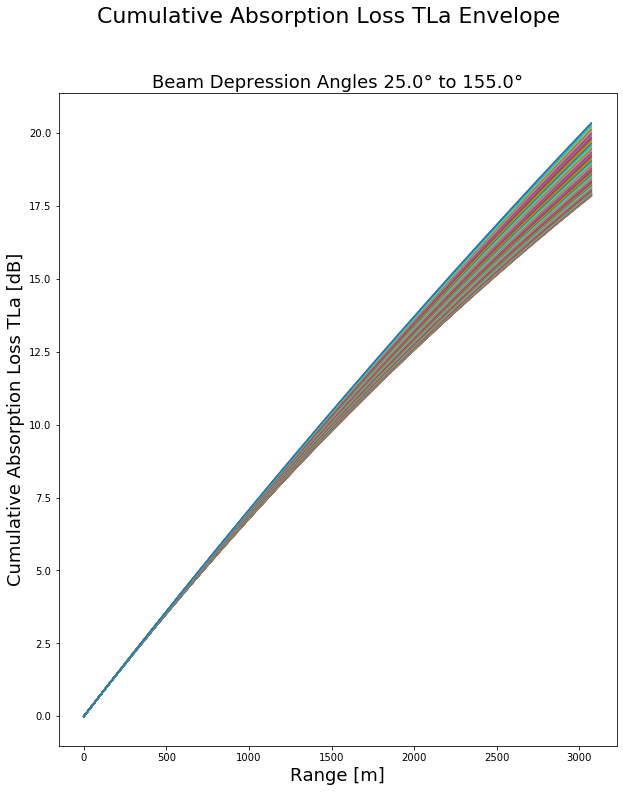

In [16]:
## 8 Show Cumulative Loss as a function of range

fig = plt.figure(figsize=(10, 12))

# Show the figure title and a plot title
fig.suptitle("Cumulative Absorption Loss TLa Envelope", fontsize = 22)
plt.title('Beam Depression Angles %.1f\u00B0 to %.1f\u00B0' %(th[0]*180/pi,th[-1]*180/pi), fontsize = 18)
plt.plot(TLa[:n_r,:])#,'DisplayName','TLa')

# Plot the labels

plt.xlabel('Range [m]',fontsize = 18)
plt.ylabel('Cumulative Absorption Loss TLa [dB]',fontsize = 18)

plt.show()
     

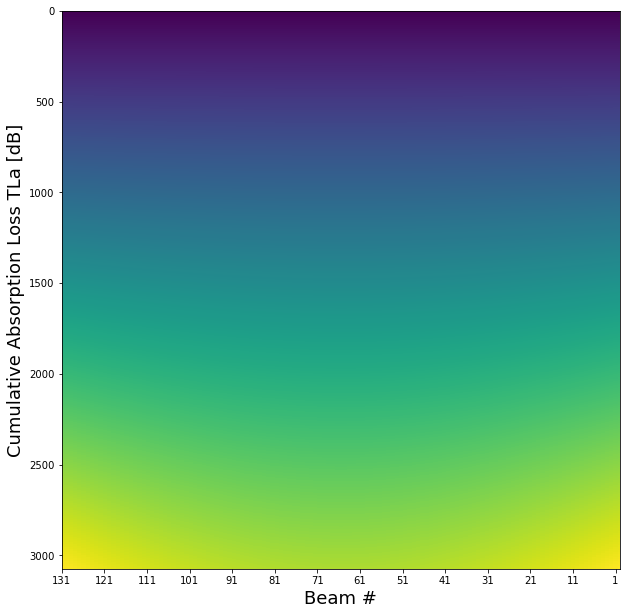

In [17]:
## 9 Show Cumulative Loss as a function of Beam and range using color

fig = plt.figure(figsize=(10, 12))

# Show the TLa, scale the x-axis date so that the image appears square
plt.imshow(scipy.ndimage.zoom(TLa[:n_r,:], (1,n_r/n_beams), order=0))

# Set the x ticks
plt.xticks(np.arange(0,n_r,n_r/n_beams*10),np.asarray(range(n_beams,0,-10)))
        
# plt.xlabel('Ensonified Area [m\N{superscript two}]',fontsize = 18)
plt.xlabel('Beam #',fontsize = 18)
plt.ylabel('Cumulative Absorption Loss TLa [dB]',fontsize = 18)

plt.show()
     

In [18]:
## 10 Create an image and mapping transform for a wedge plot
# im, X, Y, row, col = map_wedge(th,r[:n_r],y_max)
wedge = om_map()
wedge.map_wedge(th,r[:n_r],y_max)

<Figure size 720x864 with 0 Axes>

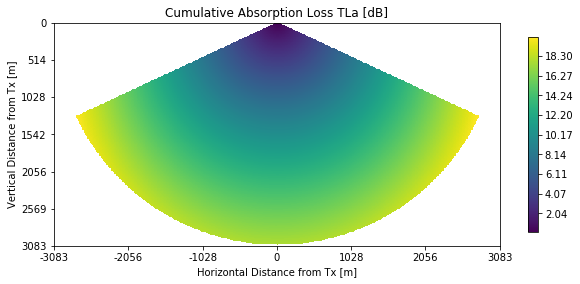

In [19]:
## 11 Plot a Wedge plot of the data

fig = plt.figure(figsize=(10, 12))
wedge.plot(TLa[:n_r,:],'Cumulative Absorption Loss TLa [dB]','1')
plt.show()

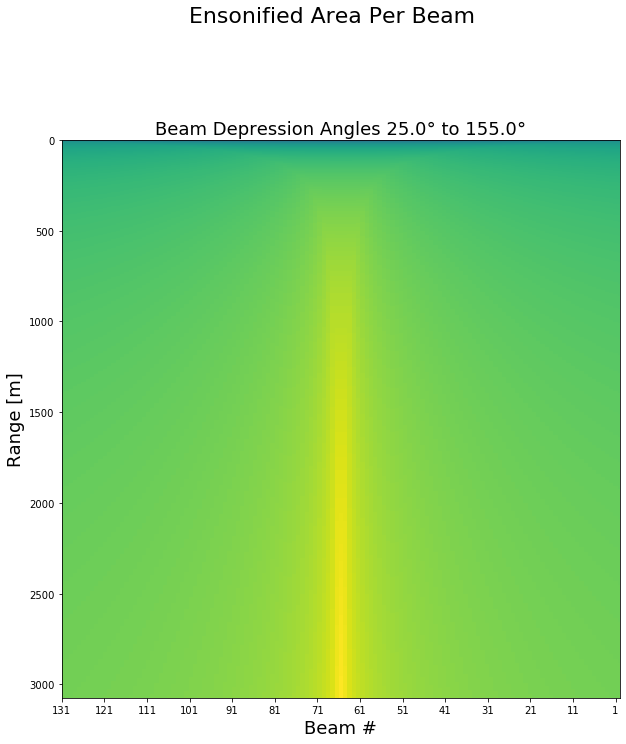

In [20]:
## 12 Plot the footprint as a function of beam and range using color

fig = plt.figure(figsize=(10, 12))

# Show the figure title and a plot title
fig.suptitle("Ensonified Area Per Beam", fontsize = 22)
plt.title('Beam Depression Angles %.1f\u00B0 to %.1f\u00B0' %(th[0]*180/pi,th[-1]*180/pi), fontsize = 18)

# Show the footprint size, scale the x-axis date so that the image appears square
plt.imshow(scipy.ndimage.zoom(EA[:n_r,:], (1,n_r/n_beams), order=0))

# Set the x ticks
plt.xticks(np.arange(0,n_r,n_r/n_beams*10),np.asarray(range(n_beams,0,-10)))
        
# plt.xlabel('Ensonified Area [m\N{superscript two}]',fontsize = 18)
plt.xlabel('Beam #',fontsize = 18)
plt.ylabel('Range [m]',fontsize = 18)

plt.show()
     

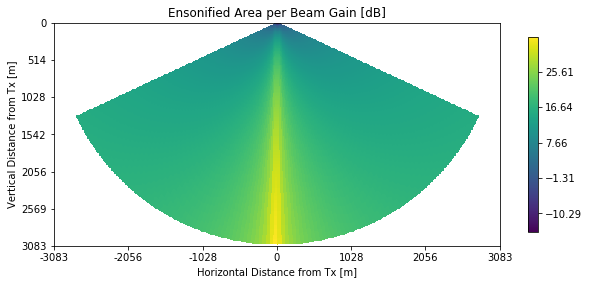

In [21]:
## 13 Plot the footprint in a wedge plot

wedge.plot(EA[:n_r,:],'Ensonified Area per Beam Gain [dB]','1')


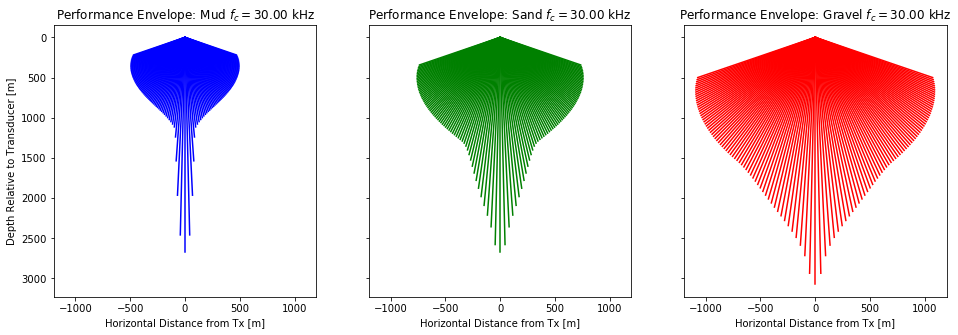

In [22]:
## 14 Plot the attainable ranges

fig, ax = plt.subplots(nrows=1,ncols=n_bot,figsize=(16, 5),sharex = True, sharey=True)

# Set a series of colors to cycle through

color = ['b','g','r','c','m','y','k']

for i in range(n_bot):

    ax[i].set_title('Performance Envelope: '+Sb[0][i]+' $f_c = $'+"%.2f kHz"%(f_c/1000))
    for j in range(n_beams):
        ax[i].plot((0,r_max[i,j]*cos(th[j])),(0,r_max[i,j]*sin(th[j])),color[i%len(color)])
        ax[i].invert_yaxis()
        ax[i].set_xlabel('Horizontal Distance from Tx [m]' )
    ax[0].set_ylabel('Depth Relative to Transducer [m]' )    
    
plt.show()
        

Essay Questions

    1. What is absolute salinity and how does it differ from practical salinity
    2. What is conservative temperature and how does it differ from in-situ temperature
    3. What does the `numpy` tile function do, and how was it used  in the `modified_lambertian()` function?

<img align="left" width="6%" style="padding-right:10px; padding-top:10px;" src="../Images/refs.png">

## Useful References

* [The official Python 3.6 documentation](https://docs.python.org/3.6/index.html)
  * [Classes](https://docs.python.org/3.6/tutorial/classes.html)
  * [String Representation Method](https://docs.python.org/3.6/reference/datamodel.html?highlight=repr#object.__str__)
* [Memory address](https://en.wikipedia.org/wiki/Memory_address)
* [ePOM: Programming Basics with Python](https://github.com/hydroffice/python_basics)
* [ePOM: Foundations of Ocean Data Science](../../ocean_data_science)


Lab C Created by John E. Hughes Clarke<br>
Python code and Notebook implementation by Semme J. Dijkstra